**EDA**


**Imports**


In [108]:
import nltk
nltk.download('vader_lexicon')
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem import WordNetLemmatizer, PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer, ENGLISH_STOP_WORDS, TfidfVectorizer
from datetime import datetime
from dateutil.parser import parse 
from google.colab import drive
drive.mount('/content/gdrive')


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


**Load Data**

In [109]:
boulderfiretweet= "/content/gdrive/MyDrive/Natural Disaster Alert System/boulder_fire_tweets.csv"
bf = pd.read_csv(boulderfiretweet)
bf.head()

,ImberJane,2022-03-28 22:56:22+00:00,RT @oliviaprentzel: Mandatory evacuation orders were issued for a wildfire just east of Estes Park... two days after the #NCAR fire sparked…,1508578772563501058
0,boulder_fire,2022-03-28 22:55:38+00:00,RT @BoulderOEM: Containment of #NCARFire is cu...,1508578590010621955
1,RachelAnneLevy,2022-03-28 22:47:19+00:00,Climate change is dangerous and costly. \n\nWe...,1508576497744891908
2,Boulderchick,2022-03-28 22:45:07+00:00,No more Fire!! #Boulder this up near Estes ht...,1508575942947467264
3,KhalaCompany,2022-03-28 22:40:19+00:00,"RT @rmpbs: ""The concern is that any time there...",1508574735940128778
4,KhalaCompany,2022-03-28 22:39:29+00:00,RT @CUBoulderENVS: As we return from Spring Br...,1508574525851672588


**Rename Column**


In [110]:
bf = bf.rename(columns={"target": "", "ImberJane": "name", "2022-03-28 22:56:22+00:00" : "date","RT @oliviaprentzel: Mandatory evacuation orders were issued for a wildfire just east of Estes Park... two days after the #NCAR fire sparked…": "text","1508578772563501058":"id"})


**Feature Engineering**

**Binarizing**

In [111]:
bf['word_count'] = bf['text'].apply(lambda x: len(x.split()))
bf['character_count'] = bf['text'].str.len()
bf['mention_count'] = bf['text'].apply(lambda x: str.count(x, '@'))

In [112]:
bf['mention'] = np.where(bf['text'].str.contains('@'), 1, 0)
bf['https'] = np.where(bf['text'].str.contains('http'), 1,0)
bf['bouldercolorado'] = np.where(bf['text'].str.contains('@bouldercolorado'), 1, 0)
bf['BeeAsMarine'] = np.where(bf['text'].str.contains('@BeeAsMarine'), 1, 0)
bf['boulder_fire'] = np.where(bf['text'].str.contains('@boulder_fire'), 1, 0)
bf.head()

,name,date,text,id,word_count,character_count,mention_count,mention,https,bouldercolorado,BeeAsMarine,boulder_fire
0,boulder_fire,2022-03-28 22:55:38+00:00,RT @BoulderOEM: Containment of #NCARFire is cu...,1508578590010621955,24,144,1,1,0,0,0,0
1,RachelAnneLevy,2022-03-28 22:47:19+00:00,Climate change is dangerous and costly. \n\nWe...,1508576497744891908,21,140,0,0,1,0,0,0
2,Boulderchick,2022-03-28 22:45:07+00:00,No more Fire!! #Boulder this up near Estes ht...,1508575942947467264,9,67,0,0,1,0,0,0
3,KhalaCompany,2022-03-28 22:40:19+00:00,"RT @rmpbs: ""The concern is that any time there...",1508574735940128778,23,139,1,1,1,0,0,0
4,KhalaCompany,2022-03-28 22:39:29+00:00,RT @CUBoulderENVS: As we return from Spring Br...,1508574525851672588,21,139,2,1,0,0,0,0


In [113]:
bf['boulder_fire'].value_counts()

0    4651
1     348
Name: boulder_fire, dtype: int64

In [114]:
bf['bouldercolorado'].value_counts()

0    4919
1      80
Name: bouldercolorado, dtype: int64

**Stop Words**

In [115]:
custom_stop = list(ENGLISH_STOP_WORDS)
custom_stop.extend(["b'RT","000", "x80", "x82", "x8f", "x99", "x94", "x98", "x99m", "x99s", "x9d", "x9f", "xa5", 
                    "xa6", "xa6'RT", "xa6'b'RT", "xa6'b'", "xb8", "xe2", "xef", "xf0", "amp", 'angele', 'angeles',
                    "b'", "Center", 'center', 'com', "Getty", 'getty', 'gettyfire', "Getty Center", "GettyFire",
                    'kincade', "instagram", "htpps", "http", "nhttp", "nhttps", 'los', "Los Angeles", "Los Angele",
                    "Los", "Angele", "outfit", 'rd', 'rt', "taco", "tick", "truck", "taco truck", "www", "instagram", 
                    "xa6'b'RT", "xa6'b'", "xa6'RT", "xb8", "x9d", "xef", "x8f", 'http','colorado','co',
                    'springs','waldo','canyon','cofire','rt','boulder','waldocanyonfire', 'highparkfire','denverpost',
                    'denver','colo', 'tickfire', 'tick', 'kincadefire', 'mariafire', 'saddleridge', 
                    'center', 'sonoma', 'sonoma county', 'county', 'https twitter', 'https', 'twitter', 'pic', 'pic twitter',
                   'don x99t', 'x99t', 'youtube', 'youtub', 'ca', 'california', 'santa clarita', 'clarita', 'don', 'santa'])

**Count Vectorizer**

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


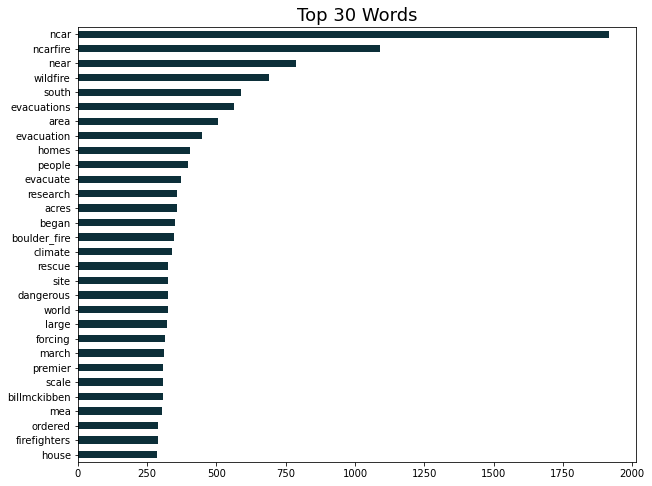

In [116]:
X = bf['text']
cvec = CountVectorizer(stop_words = custom_stop, ngram_range=(1,1), min_df = 100, max_df = .90)

words_bf = pd.DataFrame(
    cvec.fit_transform(X).todense(),
    columns = cvec.get_feature_names()
)

top_30 = words_bf.sum().sort_values(ascending = True).tail(30)
plt.title('Top 30 Words', fontsize = 18)
top_30.plot.barh(figsize = (10,8), color='#0C2F39');

**Sentiment Analysis**

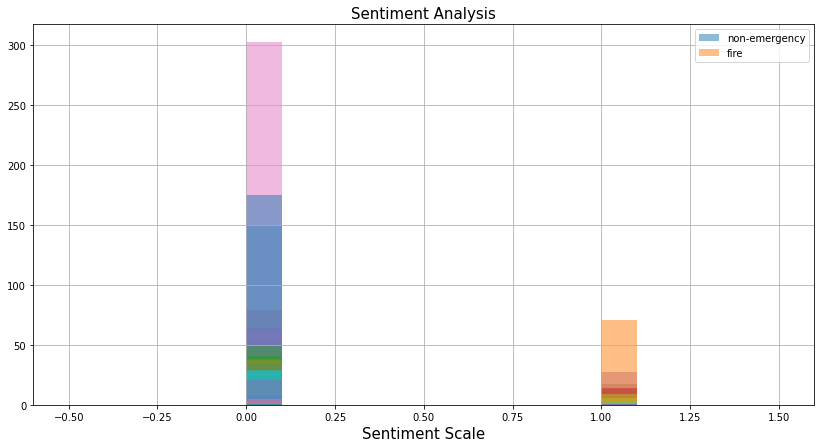

In [117]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
boulder = SentimentIntensityAnalyzer()
fig, ax1 = plt.subplots(1,1, figsize = (14,7))
bf.groupby('text')['boulder_fire'].hist(alpha = 0.5, ax = ax1)
ax1.legend(['non-emergency', 'fire'])
plt.title('Sentiment Analysis', fontsize = 15)
plt.xlabel('Sentiment Scale', fontsize = 15)
plt.show()